In [1]:
# instale as libs necessárias
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn pandas joblib matplotlib seaborn
!pip install -q fastapi uvicorn nest_asyncio pyngrok requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# train_model_colab.py (célula única)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import joblib
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ------------- parâmetros -------------
DATA_PATH = "/content/drive/MyDrive/Cardiovascular Disease dataset.zip"  # ajuste se montou Drive ou nome diferente
FEATURES = ['age','gender','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bmi']
# ---------------------------------------

# 1) carregar
df = pd.read_csv(DATA_PATH, sep=';')  # no dataset Kaggle o separador é ';' — ajuste se necessário
print("linhas:", len(df))
# limpeza básica
# converter idade (dias) para anos
df['age'] = (df['age'] / 365).round(2)
# criar BMI
df['bmi'] = df['weight'] / ((df['height']/100)**2)

# mapear gender para 0/1 (Kaggle: 1=female, 2=male) -> 0/1
if df['gender'].max() > 1:
    df['gender'] = df['gender'] - 1

    # Filtrar valores absurdos (opcional, recomendado)
    df = df[(df['ap_hi'] > 50) & (df['ap_hi'] < 300)]
    df = df[(df['ap_lo'] > 30) & (df['ap_lo'] < 200)]
    df = df[(df['height'] > 100) & (df['height'] < 230)]
    df = df[(df['weight'] > 20) & (df['weight'] < 300)]
    df = df.dropna().reset_index(drop=True)

    # 2) features e label
    X = df[FEATURES].copy()
    y = df['cardio'].values  # 0/1

    # 3) scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4) train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    # 5) transformar para tensores
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32)
    y_test_t  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)

    # 6) definir a rede
    class HeartNN(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HeartNN(len(FEATURES)).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 7) treino básico
    epochs = 50
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        # avalia no teste
        model.eval()
        with torch.no_grad():
            preds_test = model(X_test_t.to(device)).cpu().numpy().ravel()
            auc = roc_auc_score(y_test, preds_test)
            preds_bin = (preds_test >= 0.5).astype(int)
            acc = accuracy_score(y_test, preds_bin)
        print(f"Epoch {epoch}/{epochs} loss={(total_loss/len(train_ds)):.4f} AUC={auc:.4f} ACC={acc:.4f}")

    # 8) salvar modelo e scaler
    torch.save(model.state_dict(), "heart_model.pt")
    joblib.dump(scaler, "scaler.pkl")
    print("Modelo salvo: heart_model.pt ; Scaler salvo: scaler.pkl")

linhas: 70000
Epoch 1/50 loss=0.5691 AUC=0.8000 ACC=0.7347
Epoch 2/50 loss=0.5535 AUC=0.8011 ACC=0.7358
Epoch 3/50 loss=0.5513 AUC=0.8020 ACC=0.7356
Epoch 4/50 loss=0.5496 AUC=0.8021 ACC=0.7330
Epoch 5/50 loss=0.5493 AUC=0.8023 ACC=0.7355
Epoch 6/50 loss=0.5476 AUC=0.8023 ACC=0.7364
Epoch 7/50 loss=0.5472 AUC=0.8021 ACC=0.7361
Epoch 8/50 loss=0.5465 AUC=0.8026 ACC=0.7372
Epoch 9/50 loss=0.5463 AUC=0.8032 ACC=0.7357
Epoch 10/50 loss=0.5456 AUC=0.8028 ACC=0.7381
Epoch 11/50 loss=0.5457 AUC=0.8025 ACC=0.7364
Epoch 12/50 loss=0.5452 AUC=0.8031 ACC=0.7364
Epoch 13/50 loss=0.5444 AUC=0.8027 ACC=0.7349
Epoch 14/50 loss=0.5439 AUC=0.8033 ACC=0.7377
Epoch 15/50 loss=0.5444 AUC=0.8036 ACC=0.7379
Epoch 16/50 loss=0.5434 AUC=0.8032 ACC=0.7374
Epoch 17/50 loss=0.5432 AUC=0.8033 ACC=0.7372
Epoch 18/50 loss=0.5428 AUC=0.8035 ACC=0.7378
Epoch 19/50 loss=0.5429 AUC=0.8028 ACC=0.7354
Epoch 20/50 loss=0.5426 AUC=0.8030 ACC=0.7367
Epoch 21/50 loss=0.5430 AUC=0.8037 ACC=0.7385
Epoch 22/50 loss=0.5426 AUC=0

Accuracy: 0.7075714285714285
ROC AUC: 0.7672830158475152

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      7004
           1       0.71      0.70      0.71      6996

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000



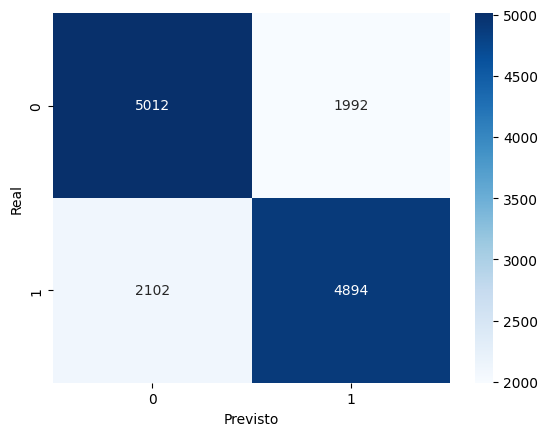

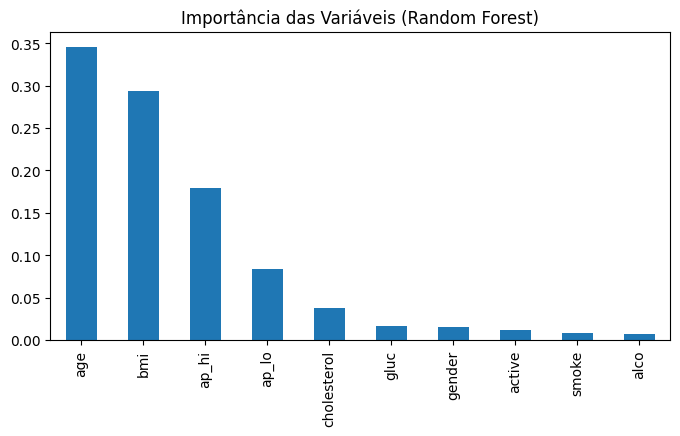

In [4]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Carregar dataset
df = pd.read_csv("/content/drive/MyDrive/Cardiovascular Disease dataset.zip", sep=";")

# Feature engineering
df['age'] = df['age'] / 365   # converter para anos
df['bmi'] = df['weight'] / ((df['height']/100)**2)

features = ['age','gender','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bmi']
X = df[features].values
y = df['cardio'].values

# Normalização
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# 3. Treinar Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

# 4. Avaliar modelo
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# 5. Importância das variáveis
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
feat_importances.plot(kind='bar', figsize=(8,4))
plt.title("Importância das Variáveis (Random Forest)")
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import numpy as np

# previsões no conjunto de teste
y_pred = (model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy() > 0.5).astype(int)

# salvar métricas em dicionário
metrics = {
    "acuracia": accuracy_score(y_test, y_pred),
    "precisao_1": precision_score(y_test, y_pred, pos_label=1),
    "precisao_0": precision_score(y_test, y_pred, pos_label=0),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
}

# salvar em arquivo para carregar no bot
joblib.dump(metrics, "metrics.pkl")
print("Métricas salvas em metrics.pkl:", metrics)

Métricas salvas em metrics.pkl: {'acuracia': 0.6592142857142858, 'precisao_1': 0.7143958373482366, 'precisao_0': 0.6267166042446941, 'recall': 0.529874213836478, 'f1': 0.6084530160032827}


In [6]:
import numpy as np, joblib, torch
from math import pow

# carregar
scaler = joblib.load("scaler.pkl")
model = HeartNN(len(FEATURES))
model.load_state_dict(torch.load("heart_model.pt", map_location=torch.device('cpu')))
model.eval()

def predict_dict(d):
    # d: dict com chaves: age (anos), gender (0/1), ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, height, weight
    # calculamos bmi aqui se o usuário deu peso/altura
    if 'bmi' not in d and ('height' in d and 'weight' in d):
        d['bmi'] = d['weight'] / ((d['height']/100)**2)
    X = np.array([[ d[k] for k in FEATURES ]], dtype=float)
    Xs = scaler.transform(X)
    xt = torch.tensor(Xs, dtype=torch.float32)
    with torch.no_grad():
        prob = model(xt).item()
    return prob

# exemplo
ex = {'age':45, 'gender':1, 'ap_hi':130, 'ap_lo':85, 'cholesterol':2, 'gluc':1, 'smoke':0, 'alco':0, 'active':1, 'height':170, 'weight':75}
p = predict_dict(ex)
print("Probabilidade:", p, "->", f"{p*100:.1f}%")

Probabilidade: 0.6395558714866638 -> 64.0%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [7]:
# webhook_bot_api.py
from fastapi import FastAPI, Request
import requests, joblib, torch, numpy as np
from pyngrok import ngrok
import nest_asyncio, uvicorn

# --- config: cole seus tokens ---
BOT_TOKEN = "8023980472:AAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0"
NGROK_TOKEN = "32qY5dLWWTolN1ycUWtW31QV7LL_4AEYAYkqk3wpj8ZTLYM7G"
# ---------------------------------

# carregar scaler e modelo (usa CPU na inferência)
scaler = joblib.load("scaler.pkl")
# Assuming HeartNN is defined elsewhere in the notebook
# If not, you'll need to define it before this cell
# from train_model_colab import HeartNN # Uncomment and adjust if HeartNN is in another file
class HeartNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = HeartNN(10) # Assuming 10 features based on the previous cell
model.load_state_dict(torch.load("heart_model.pt", map_location=torch.device('cpu')))
model.eval()

# dados do estado de conversa (em memória)
CONV = {}  # chat_id -> {stage:int, data:dict}

QUESTIONS = [
    ("age", "Qual sua idade (em anos)?"),
    ("gender", "Qual Seu Sexo? Responda 'M' ou 'F'"),
    ("height", "Qual Sua Altura em cm? (ex: 170)"),
    ("weight", "Qual Seu Peso em kg? (ex: 75)"),
    ("ap_hi", "Qual Sua Pressão sistólica (valor numérico, ex: 120)"),
    ("ap_lo", "Qual Pressão diastólica (ex: 80)"),
    ("cholesterol", "Colesterol (1=Normal, 2=Acima, 3=Muito acima)"),
    ("gluc", "Nível de Glicemia (1=Normal,2=Acima,3=Muito acima)"),
    ("smoke", "Você fuma? Responda 'sim' ou 'não'"),
    ("alco", "Você Consome álcool frequentemente? 'sim'/'não'"),
    ("active", "Você Pratica atividade física? 'sim'/'não'")
]

def send_message(chat_id, text):
    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage"
    requests.post(url, json={"chat_id": chat_id, "text": text})

def normalize_answer(key, text):
    text = text.strip().lower()
    if key == "gender":
        if text.startswith('m'):
            return 1  # considere 1 = male
        else:
            return 0  # female
    if key in ("smoke","alco","active"):
        return 1 if text.startswith('s') or text.startswith('y') else 0
    try:
        return float(text)
    except:
        return None

def compute_probability(data):
    # data must contain keys: age, gender, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, height, weight or bmi
    if 'bmi' not in data:
        data['bmi'] = data['weight'] / ((data['height']/100)**2)
    FEATURES = ['age','gender','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','bmi'] # Define FEATURES here or load from elsewhere
    arr = np.array([[ data[k] for k in FEATURES ]], dtype=float)
    arrs = scaler.transform(arr)
    xt = torch.tensor(arrs, dtype=torch.float32)
    with torch.no_grad():
        prob = model(xt).item()
    return prob

app = FastAPI()

@app.post("/webhook/{token}")
async def telegram_webhook(token: str, request: Request):
    if token != BOT_TOKEN:
        return {"ok": False, "error": "token mismatch"}
    upd = await request.json()
    # process message
    msg = upd.get("message")
    if not msg:
        return {"ok": True}
    chat_id = msg["chat"]["id"]
    text = msg.get("text", "").strip()
    # iniciar conversa
    if text.lower() == "/start":
        CONV[chat_id] = {"stage": 0, "data": {}}
        send_message(chat_id, "Olá! Vou calcular uma estimativa de risco. Preciso de alguns dados. (Sempre responda com números ou 'sim/nao').")
        send_message(chat_id, QUESTIONS[0][1])
        return {"ok": True}
    # se sem conversa, pedir para iniciar
    if chat_id not in CONV:
        send_message(chat_id, "Envie /start para começar.")
        return {"ok": True}
    # pegar estágio atual
    stage = CONV[chat_id]["stage"]
    key = QUESTIONS[stage][0]
    val = normalize_answer(key, text)
    if val is None:
        send_message(chat_id, "Entrada inválida. Por favor insira um valor numérico ou 'sim/nao'.")
        send_message(chat_id, QUESTIONS[stage][1])
        return {"ok": True}
    # salvar
    CONV[chat_id]["data"][key] = val
    CONV[chat_id]["stage"] += 1
    # next question or compute
    if CONV[chat_id]["stage"] < len(QUESTIONS):
        send_message(chat_id, QUESTIONS[ CONV[chat_id]['stage'] ][1])
    else:
        data = CONV[chat_id]["data"]
        prob = compute_probability(data)
        pct = prob * 100

        if prob < 0.10:
            risk = "Baixo"
        elif prob < 0.4:
            risk = "Médio"
        else:
            risk = "Alto"

        # resposta detalhada
        # Load metrics here as they might not be in the global scope of this function
        try:
          metrics = joblib.load("metrics.pkl")
        except FileNotFoundError:
          metrics = {"acuracia": 0, "precisao_0": 0, "precisao_1": 0, "recall": 0, "f1": 0} # Default if metrics not found

        resposta = f"🧾 Resultado da Avaliação de Risco\n\n"
        resposta += f"📊 Probabilidade estimada de ataque cardíaco em 10 anos: {pct:.1f}%\n"
        resposta += f"Risco: {risk}\n\n"
        resposta += "🔍 Sobre o modelo de IA:\n"
        resposta += f" • Acurácia: {metrics['acuracia']*100:.2f}%\n"
        resposta += f" • Precisão (sem risco): {metrics['precisao_0']*100:.2f}%\n"
        resposta += f" • Precisão (com risco): {metrics['precisao_1']*100:.2f}%\n"
        resposta += f" • Recall (detecção de risco): {metrics['recall']*100:.2f}%\n"
        resposta += f" • F1-Score: {metrics['f1']*100:.2f}%\n\n"
        resposta += "⚠️ Este resultado é apenas uma estimativa. Procure atendimento médico para avaliação completa."

        send_message(chat_id, resposta)

        # limpar conversa
        del CONV[chat_id]

    return {"ok": True}



URL pública (ngrok): https://39879aac919b.ngrok-free.app


INFO:     Started server process [356]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


setWebhook response: {'ok': True, 'result': True, 'description': 'Webhook was set'}
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [356]


In [9]:
# --- Iniciar ngrok e setar webhook (execute quando pronto) ---
ngrok.set_auth_token(NGROK_TOKEN)
public_url = ngrok.connect(8000).public_url
print("URL pública (ngrok):", public_url)

# registrar webhook no Telegram (troque BOT_TOKEN se diferente)
resp = requests.get(f'https://api.telegram.org/bot{BOT_TOKEN}/setWebhook?url={public_url}/webhook/{BOT_TOKEN}')
print("setWebhook response:", resp.json())

# iniciar o servidor (bloqueante) - execute a célula e mantenha ela rodando
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)

URL pública (ngrok): https://7911eed45a26.ngrok-free.app
setWebhook response: {'ok': True, 'result': True, 'description': 'Webhook was set'}


INFO:     Started server process [356]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK
INFO:     91.108.5.76:0 - "POST /webh

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     91.108.5.76:0 - "POST /webhook/8023980472%3AAAGsr_115dRvxIddQ8lnQL_-28d1k6zt8u0 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [356]


In [8]:
# carregar scaler e modelo
scaler = joblib.load("scaler.pkl")
model = HeartNN(len(FEATURES))
model.load_state_dict(torch.load("heart_model.pt", map_location=torch.device('cpu')))
model.eval()

# carregar métricas
metrics = joblib.load("metrics.pkl")

In [10]:
# Configuração inicial
!git config --global user.name "LucianoCarvalho1998"
!git config --global user.email "2021006135@ifam.edu.br"
